In [4]:
import pandas as pd
import os 

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

import seaborn as sns
import numpy as np

from pytimekr import pytimekr

import warnings
warnings.filterwarnings(action='ignore')

In [7]:
database = pd.read_csv('./data/train_preprocessed.csv')
database['tm'] = pd.to_datetime(database['tm'])
database.head()

,tm,year,season,month,day,hh24,weekday,week_name,sin_time,cos_time,num,stn,nph_ta,nph_hm,CDH,THI,nph_ws_10m,nph_rn_60m,nph_ta_chi,elec
0,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,13615,140,-8.5,74.5,-34.5,1.538975,0.9,0.0,-5.8,99.63
1,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,18235,565,-8.8,25.6,-34.8,7.943264,1.9,0.0,-4.6,103.49
2,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,18234,565,-8.8,25.6,-34.8,7.943264,1.9,0.0,-4.6,104.43
3,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,18233,512,-6.3,31.3,-32.3,9.196031,2.5,0.0,-7.8,106.29
4,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,11272,941,2.4,68.0,-23.6,19.353600,1.2,0.0,-5.3,102.45


### 그룹화 

격자 종류가 너무 많다. 온도와 습도, 풍속을 측정한 값이 같으면 같은 지역이라고 할 수 있다. 

온도와 습도, 풍속이 같은 값끼리 그룹화를 해보자 

또는 같은 AWS 측정 넘버가 같은것끼리 그룹화를 해본다.

In [9]:
# 먼저 2020년 기록이 있는 데이터와 없는 데이터끼리 나눠보자 
spots_num = sorted(database['num'].unique().tolist())
df_1 = database[database['num']==spots_num[1]]

print(df_1['tm'].min(), df_1['tm'].max())

no_2020 = []
yes_2020 = []
for i in range(len(spots_num)):
    a = str(database[database['num']==spots_num[i]]['tm'].min())
    b = str(df_1['tm'].min())

    if a != b:
        no_2020.append(spots_num[i])
    else:
        yes_2020.append(spots_num[i])
        
print(len(no_2020))  # 2020년도 데이터가 없는 격자 지역 개수 23개
print(len(yes_2020)) # 2020년도 데이터가 있는 격자 지역 개수 300개

2020-01-01 01:00:00 2023-01-01 00:00:00
23
300


In [10]:
df1 = database[database['num'].isin(yes_2020)]
df2 = database[database['num'].isin(no_2020)]

In [15]:
print(df2['num'].unique())

print(len(df2['num'].unique()))

[16900 16913 18828 14378 14258 15849 13648  4821  8994 10224 10975 12618
 12467 12322 13202 12619 11271 11562 11376 11119  9609 10976 13360]
23


In [16]:
print(df2['stn'].unique())

print(len(df2['stn'].unique()))

[495 127 511 605 138 177 845 884 261 313 942 152 900 901 827 941 899 252
 908 168 283]
21


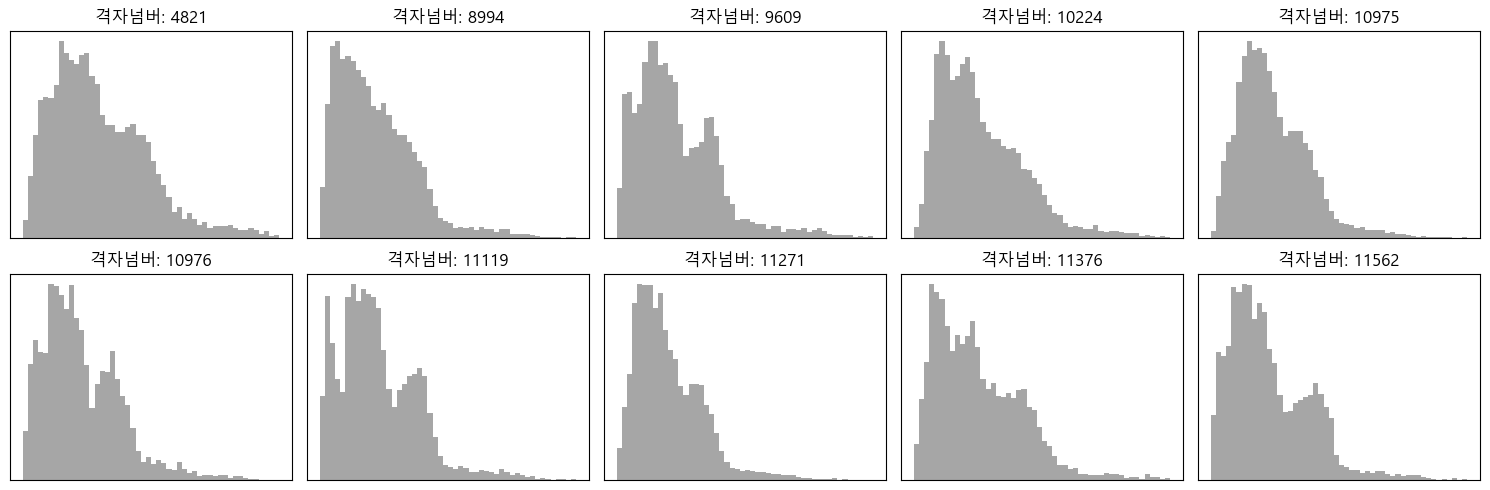

In [20]:
fig = plt.figure(figsize = (15, 5))
for idx, num in enumerate(no_2020[:10]):
    ax = plt.subplot(2, 5, 1+idx)
    energy = df2.loc[df2['num'] == no_2020[idx], 'elec'].values
    mean = energy.mean().round(3)           # 평균
    std = energy.std().round(3)             # 편차
    skew = (3*(mean - np.median(energy))/energy.std()).round(3) # 왜도

    # 왜도에 따라 
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
        
    plt.title(f'격자넘버: {no_2020[idx]}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    
plt.tight_layout()
plt.show()

In [ ]:
## chk feature correlation visually

fig, axes = plt.subplots(2, 4, figsize=(10,7))

df2.plot(x='nph_ta', y='elec', kind='scatter', alpha=0.1, ax=axes[1,0])
df2.plot(x='nph_hm', y='elec', kind='scatter', alpha=0.1, ax=axes[1,1])
df2.plot(x='nph_ws_10m', y='elec', kind='scatter', alpha=0.1, ax=axes[0])
df2.plot(x='nph_rn_60m', y='elec', kind='scatter', alpha=0.1, ax=axes[1])
df2.plot(x='nph_ta_chi', y='elec', kind='scatter', alpha=0.1, ax=axes[2])


fig.tight_layout()

In [ ]:
s = database[database.datetime=='2020-06-01 00:00:00'].groupby(['temperature', 'windspeed']).ngroup()
s.name = 'mgrp'